In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def cis_sig_status(row):
    if row.cis_HUES64_status == "significant cis effect" and row.cis_mESC_status == "significant cis effect":
        return "sig_both"
    elif row.cis_HUES64_status == "significant cis effect" and row.cis_mESC_status == "no cis effect":
        return "sig_human"
    elif row.cis_HUES64_status == "no cis effect" and row.cis_mESC_status == "significant cis effect":
        return "sig_mouse"
    else:
        return "not_sig_both"

## variables

In [6]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [7]:
data = pd.read_table(data_f, sep="\t")
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect


## 2. filter data

In [8]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

5438

In [9]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

2285

In [10]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

2272

In [11]:
data_filt_tile1 = data_filt[data_filt["tss_tile_num"] == "tile1"]
len(data_filt_tile1)

1392

In [12]:
data_filt_tile1_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile1"]
len(data_filt_tile1_sp)

1382

In [13]:
data_filt_tile2 = data_filt[data_filt["tss_tile_num"] == "tile2"]
len(data_filt_tile2)

893

In [14]:
data_filt_tile2_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile2"]
len(data_filt_tile2_sp)

890

## 3. counts of cis effects

In [15]:
dfs = [data_filt_sp, data_filt_tile1_sp, data_filt_tile2_sp]
titles = ["both tiles", "tile1 only", "tile2 only"]
labels = ["both_tiles", "tile1_only", "tile2_only"]

In [16]:
cis_order = ["no cis effect", "significant cis effect"]
cis_pal = {"no cis effect": "gray", "significant cis effect": "black"}

det_order = ["cis effect\n(higher in human)", "cis effect\n(higher in mouse)"]
complete_pal = {"cis effect\n(higher in human)": sns.color_palette("Set2")[1],
                "cis effect\n(higher in mouse)": sns.color_palette("Set2")[0]}
det_pal = {"cis effect\n(higher in human)": sns.light_palette(sns.color_palette("Set2")[1])[2],
           "cis effect\n(higher in mouse)": sns.light_palette(sns.color_palette("Set2")[0])[2]}

percent cis sig: 0.397887323943662


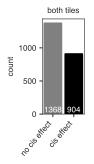

percent cis sig: 0.3907380607814761


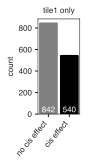

percent cis sig: 0.40898876404494383


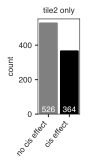

In [17]:
for df, title, label in zip(dfs, titles, labels):
    
    fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

    sns.countplot(data=df, x="cis_status_one", palette=cis_pal, order=cis_order, linewidth=2, 
                  edgecolor=cis_pal.values(), ax=ax)
    ax.set_xticklabels(["no cis effect", "cis effect"], va="top", ha="right", rotation=50)
    ax.set_xlabel("")
    ax.set_title(title)
    
    tot = 0
    for i, l in enumerate(cis_order):
        n = len(df[df["cis_status_one"] == l])
        tot += n
        ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color="white", size=fontsize)
    print("percent cis sig: %s" % (n/tot))

    plt.show()
    fig.savefig("count_cis_status.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 4. plot cis effect sizes between HUES64 and mESC

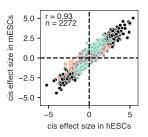

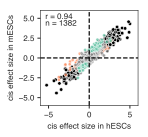

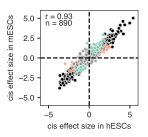

In [18]:
for df, title, label in zip(dfs, titles, labels):
    
    df["cis_sig_status"] = df.apply(cis_sig_status, axis=1)
    
    # plot effect size agreement b/w the two cells
    fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

    sig_human = df[df["cis_sig_status"] == "sig_human"]
    sig_mouse = df[df["cis_sig_status"] == "sig_mouse"]
    sig_both = df[df["cis_sig_status"] == "sig_both"]
    not_sig = df[df["cis_sig_status"] == "not_sig_both"]

    ax.scatter(sig_both["logFC_cis_HUES64"], sig_both["logFC_cis_mESC"], s=12, alpha=1, 
               color="black", linewidths=0.5, edgecolors="white")
    ax.scatter(sig_human["logFC_cis_HUES64"], sig_human["logFC_cis_mESC"], s=10, alpha=0.75, 
               color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
    ax.scatter(not_sig["logFC_cis_HUES64"], not_sig["logFC_cis_mESC"], s=10, alpha=0.75, 
               color="gray", linewidths=0.5, edgecolors="white")
    ax.scatter(sig_mouse["logFC_cis_HUES64"], sig_mouse["logFC_cis_mESC"], s=10, alpha=0.75, 
               color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")

    plt.xlabel("cis effect size in hESCs")
    plt.ylabel("cis effect size in mESCs")

    ax.axhline(y=0, color="black", linestyle="dashed")
    ax.axvline(x=0, color="black", linestyle="dashed")
    ax.set_xlim((-6, 6))
    ax.set_ylim((-6, 6))

    # annotate corr
    no_nan = df[(~pd.isnull(df["logFC_cis_HUES64"])) & (~pd.isnull(df["logFC_cis_mESC"]))]
    r, p = spearmanr(no_nan["logFC_cis_HUES64"], no_nan["logFC_cis_mESC"])
    ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    plt.show()
    fig.savefig("cis_effect_bw_cells_scatter.sig_status_color.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 5. effect size differences across biotypes

In [19]:
min_switch_order = ["CAGE turnover - eRNA", "CAGE turnover - lncRNA", "CAGE turnover - mRNA", 
                    "eRNA", "lncRNA", "mRNA"]
min_switch_pal = {"CAGE turnover - eRNA": sns.color_palette("Set2")[2], 
                  "CAGE turnover - lncRNA": sns.color_palette("Set2")[2],
                  "CAGE turnover - mRNA": sns.color_palette("Set2")[2],
                  "eRNA": sns.color_palette("Set2")[7], 
                  "lncRNA": sns.color_palette("Set2")[7], 
                  "mRNA": sns.color_palette("Set2")[7]}

CAGE turnover - eRNA median eff size: 1.24862095970173
CAGE turnover - lncRNA median eff size: 1.09946818724604
CAGE turnover - mRNA median eff size: 1.2973232166138
eRNA median eff size: 1.00153932412008
lncRNA median eff size: 0.9360008353217992
mRNA median eff size: 0.895678390562887


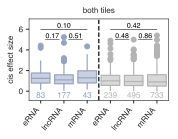

CAGE turnover - eRNA median eff size: 1.245513499788715
CAGE turnover - lncRNA median eff size: 1.1140153541407851
CAGE turnover - mRNA median eff size: 1.71241123097117
eRNA median eff size: 0.8929499668445424
lncRNA median eff size: 0.9330057401481942
mRNA median eff size: 0.8117220715433554


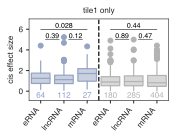

CAGE turnover - eRNA median eff size: 1.37192910823102
CAGE turnover - lncRNA median eff size: 0.98947468181828
CAGE turnover - mRNA median eff size: 1.0369626363630566
eRNA median eff size: 1.17102245776855
lncRNA median eff size: 0.9533364066183825
mRNA median eff size: 0.99229344607925


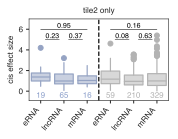

In [20]:
for df, title, label in zip(dfs, titles, labels):
    df["abs_logFC_cis"] = np.abs(df["logFC_cis_one"])
    #df = df[df["native_status"] == "significant native effect"]

    fig = plt.figure(figsize=(2.5, 1.5))
    ax = sns.boxplot(data=df, x="biotype_switch_minimal", y="abs_logFC_cis", 
                     flierprops = dict(marker='o', markersize=5), 
                     order=min_switch_order, palette=min_switch_pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("cis effect size")
    ax.set_title(title)

    for i, l in enumerate(min_switch_order):
        sub = df[df["biotype_switch_minimal"] == l]
        n = len(sub)
        print("%s median eff size: %s" % (l, sub["abs_logFC_cis"].median()))
        color = min_switch_pal[l]
        ax.annotate(str(n), xy=(i, -0.8), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)
        
    ### pvals ###
    vals1 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - eRNA"]["abs_logFC_cis"])
    vals2 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - lncRNA"]["abs_logFC_cis"])
    vals3 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - mRNA"]["abs_logFC_cis"])
    vals4 = np.asarray(df[df["biotype_switch_minimal"] == "eRNA"]["abs_logFC_cis"])
    vals5 = np.asarray(df[df["biotype_switch_minimal"] == "lncRNA"]["abs_logFC_cis"])
    vals6 = np.asarray(df[df["biotype_switch_minimal"] == "mRNA"]["abs_logFC_cis"])
    
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    vals3 = vals3[~np.isnan(vals3)]
    vals4 = vals4[~np.isnan(vals4)]
    vals5 = vals5[~np.isnan(vals5)]
    vals6 = vals6[~np.isnan(vals6)]
    
    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    _, pval13 = stats.mannwhitneyu(vals1, vals3, alternative="two-sided", use_continuity=False)
    _, pval23 = stats.mannwhitneyu(vals2, vals3, alternative="two-sided", use_continuity=False)
    _, pval45 = stats.mannwhitneyu(vals4, vals5, alternative="two-sided", use_continuity=False)
    _, pval46 = stats.mannwhitneyu(vals4, vals6, alternative="two-sided", use_continuity=False)
    _, pval56 = stats.mannwhitneyu(vals5, vals6, alternative="two-sided", use_continuity=False)
    
    annotate_pval(ax, 0.2, 0.8, 5, 0, 5, pval12, fontsize-1)
    annotate_pval(ax, 1.2, 1.8, 5, 0, 5, pval13, fontsize-1)
    annotate_pval(ax, 0, 2, 6, 0, 6, pval23, fontsize-1)
    annotate_pval(ax, 3.2, 3.8, 5, 0, 5, pval45, fontsize-1)
    annotate_pval(ax, 4.2, 4.8, 5, 0, 5, pval56, fontsize-1)
    annotate_pval(ax, 3, 5, 6, 0, 6, pval46, fontsize-1)

    ax.set_ylim((-0.9, 7))
    ax.axvline(x=2.5, linestyle="dashed", color="black")

    plt.show()
    fig.savefig("cis_minimal_biotype_switch_effectsize_boxplot.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

In [21]:
def cage_status(row):
    if "CAGE turnover" in row.biotype_switch_minimal:
        return "turnover"
    else:
        return "conserved"

In [22]:
def one_biotype(row):
    if row.minimal_biotype_hg19 == "no CAGE activity":
        return row.minimal_biotype_mm9
    else:
        return row.minimal_biotype_hg19

In [23]:
pal = {"conserved": sns.color_palette("Set2")[7], "turnover": sns.color_palette("Set2")[2]}

0.00844638125901
0.00878430061977
0.00383799208728
0.0101938107104
0.00421618182537
0.00062198959956
0.485254781157
0.460223395459
0.809999066299


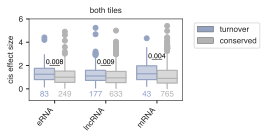

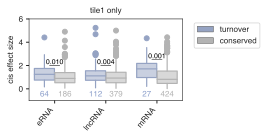

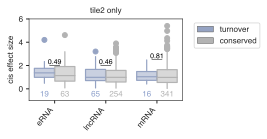

In [24]:
for df, title, pltname in zip(dfs, titles, labels):
    df["abs_logFC_cis"] = np.abs(df["logFC_cis_one"])
    df["cage_status"] = df.apply(cage_status, axis=1)
    df["one_biotype"] = df.apply(one_biotype, axis=1)
    
    fig = plt.figure(figsize=(2.75, 1.5))

    ax = sns.boxplot(data=df, x="one_biotype", y="abs_logFC_cis", hue="cage_status",
                     flierprops = dict(marker='o', markersize=5),
                     order=["eRNA", "lncRNA", "mRNA"], hue_order=["turnover", "conserved"], palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("cis effect size")
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

    ys = [2, 2, 2.5]
    for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
        sub = df[df["one_biotype"] == label]
        sub1 = sub[sub["cage_status"] == "turnover"]
        sub2 = sub[sub["cage_status"] == "conserved"]

        vals1 = np.asarray(sub1["abs_logFC_cis"])
        vals2 = np.asarray(sub2["abs_logFC_cis"])

        vals1 = vals1[~np.isnan(vals1)]
        vals2 = vals2[~np.isnan(vals2)]

        u, pval = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
        print(pval)

        if pval >= 0.05:
            annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)
        else:
            annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)

        n1 = len(vals1)
        n2 = len(vals2)

        ax.annotate(str(n1), xy=(i-0.2, -0.8), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=pal["turnover"], size=fontsize)
        ax.annotate(str(n2), xy=(i+0.2, -0.8), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=pal["conserved"], size=fontsize)

    ax.set_ylim((-1, 6))
    ax.set_title(title)
    fig.savefig("cis_effect_biotype_sep_cage.%s.pdf" % pltname, dpi="figure", bbox_inches="tight")

## 6. percent sig across biotypes

CAGE turnover - eRNA perc sig: 56.6265060241
CAGE turnover - lncRNA perc sig: 45.197740113
CAGE turnover - mRNA perc sig: 53.488372093
eRNA perc sig: 43.5146443515
lncRNA perc sig: 35.9595959596
mRNA perc sig: 37.380627558


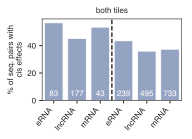

CAGE turnover - eRNA perc sig: 54.6875
CAGE turnover - lncRNA perc sig: 45.5357142857
CAGE turnover - mRNA perc sig: 62.962962963
eRNA perc sig: 39.4444444444
lncRNA perc sig: 35.7894736842
mRNA perc sig: 33.9108910891


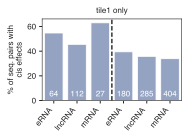

CAGE turnover - eRNA perc sig: 63.1578947368
CAGE turnover - lncRNA perc sig: 44.6153846154
CAGE turnover - mRNA perc sig: 37.5
eRNA perc sig: 55.9322033898
lncRNA perc sig: 36.1904761905
mRNA perc sig: 41.641337386


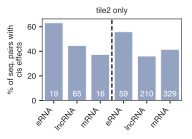

In [25]:
for df, title, label in zip(dfs, titles, labels):

    tots = df.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
    sig = df[df["cis_status_one"] != "no cis effect"].groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
    clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
    clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
    
    fig = plt.figure(figsize=(2.5, 1.5))
    ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
                     order=min_switch_order, color=sns.color_palette("Set2")[2])

    ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("% of seq. pairs with\ncis effects")
    ax.set_title(title)
    ax.axvline(x=2.5, linestyle="dashed", color="black")
    
    for i, l in enumerate(min_switch_order):
        sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
        print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
        n = sub["hg19_id_x"].iloc[0]
        ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color="white", size=fontsize)
    
    plt.show()
    fig.savefig("perc_sig_cis_minimal_biotype_switch.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()